_Since we announced [our collaboration with the World Bank and more partners to create the Open Traffic platform](https://mapzen.com/blog/announcing-open-traffic/), we’ve been busy. We’ve shared [two](https://mapzen.com/blog/open-traffic-osmlr-technical-preview/) [technical](https://mapzen.com/blog/osmlr-2nd-technical-preview/) previews of the OSMLR linear referencing system. Now we’re ready to share more about how we’re using [Mapzen Map Matching](https://mapzen.com/blog/map-matching/) to “snap” GPS-derived locations to OSMLR segments, and how we’re using a data-driven approach to evaluate and improve the algorithms._

# A "data-driven" approach to improving map-matching - Part III: 
## _POST-PROCESSING_
=============================================================================================

So far, we've seen how Mapzen uses synthetic GPS data to [validate](http://nbviewer.jupyter.org/github/opentraffic/reporter-quality-testing-rig/blob/23b90405f2d094c015a3438426a9a5d338b86c46/notebooks/map_matching_part_I.ipynb) the our map-matching results, and also how we use those validation metrics to [optimize](http://nbviewer.jupyter.org/github/opentraffic/reporter-quality-testing-rig/blob/master/notebooks/map_matching_part_II.ipynb) our algorithm performance for each one of our Open Traffic partners. For the third installment of our series on data-driven map-matching, we'll discuss the post-processing we do to ensure that only the best-quality matches make their way into the Open Traffic datastore.

## Background

As previously discussed [here](link to second blog post), Mapzen's map-matching algorithm relies on a kind of graphical model known as a Hidden Markov Model (HMM). Because HMM's are probabilistic in nature, the matches returned by the algorithm will always only be a best guess. Unforunately, this best guess may still be quite far from the "truth" -- AKA **wrong**. 

To make sure we aren't serving up generating conditions based on junk data, we would like some method for filtering out match results that just aren't realistic before they make their way to the Open Traffic datastore. One such approach we at Mapzen have developed is based on driving **driving speeds**.

## Hypothesis

Although GPS can often have very poor positional accuracy, its temporal measurements are rarely off by more than a [nanosecond](http://www.atomic-clock.galleon.eu.com/support/gps-time-accuracy.html). Because of this temporal precision, we can assert that any candidate route matched between two GPS data points must traverse its path in exactly the amount of time elapsed between the measurements. What this means is that a truly wacky match -- one that takes detours down side streets or doubles back on itself -- is going to have a lot of additional ground to cover in the same amount of time. In other words, the driver on this hypothetical, wacky route would have to be going _very_ fast.

The match error diagram from [Newton and Krumm (2009)](http://research.microsoft.com/en-us/um/people/jckrumm/Publications%202009/map%20matching%20ACM%20GIS%20camera%20ready.pdf) helps illustrate how we might construct a speed-based error metric:

<img src="krumm_newson_dist.png" alt="Drawing" style="width: 400px;" align="center"/>
<center><i>From Newton and Krumm (2009)</i></center>

Imagine that we have two GPS measurements on either end of the route shown above. Clearly, someone driving along the matched route would need to drive nearly twice as fast as someone on the correct route in order to traverse their paths in the same amount of time. Therefore, if we know that the average speed limit along the matched route is 50 km/h, and the speed we derive from our GPS measurements is 100 km/h, we probably have a bad match. Our hypothesis is that because bad matches are more likely to generate unreasonably high speeds relative to the known [speed limits](http://wiki.openstreetmap.org/wiki/Speed_limits) along a route, **we should therefore be able to identify bad matches based on the magnitude of this speed error**.

Below, we attempt to learn from our simulated GPS traces what the optimal threshold for such a speed-based error metric might be.

## 0. Setup test environment

In [1]:
import os
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
import numpy as np
from random import choice
import pandas as pd
%matplotlib inline

#### User vars

In [2]:
mapzenKey = os.environ.get('MAPZEN_API')
gmapsKey = os.environ.get('GOOGLE_MAPS')

## 1. Generate routes & metrics

For this analysis, we'll revert back to our original study area in San Francisco, CA

In [3]:
cityName = 'San Francisco'
minRouteLen = 1     # specified in km
maxRouteLen = 5     # specified in km
numRoutes = 100

In [4]:
routes = val.get_routes_by_length(cityName, minRouteLen, maxRouteLen, numRoutes, mapzenKey)

In [4]:
sampleRates = [1, 5, 10, 20, 30]    # specified in seconds
noiseLevels = np.linspace(0, 100, 21)    # specified in meters

The previous bits of code should look familiar to you if you've been following these map-matching tutorials from the beginning. The only difference here is that rather than scoring matches, we're interested in score speeds. Thus, we can toss the first object returned by `get_route_metrics()` and store the second, which correspond to the match and speed dataframes, respectively:

In [27]:
_, speedDf, _ = val.get_route_metrics(cityName, routes, sampleRates, noiseLevels, saveResults=True)

A random 5 entries from the speed metric dataframe:

In [15]:
speedDf.sample(5)

,matched,noise,pct_error,route_name,sample_rate,segment_id
206682,True,45.0,0.073008,Russell Ng_to_Lee Hecht Harrison,5.0,85569690162
271234,False,70.0,0.460363,Nan D Schlosberg_to_Total Logistics Resource Inc,10.0,825545579058
174527,True,10.0,-0.030170,Sweet Sue's_to_All Metals Welding,1.0,122272716425
248699,True,55.0,-0.086480,Something Very Special_to_ECOR Clothing Enterp...,10.0,500531484576
46216,False,85.0,0.373544,AAABE Co_to_Street P,30.0,287662511753


In [5]:
speedDf = pd.read_csv('london_speeds.csv')

## 2. Calculate and plot the optimal speed error threshold

We define speed error in the following way:
$$ \text{speed error} = \frac{\text{GPS-derived speed} - \text{known speed}}{\text{known speed}}$$

The optimal speed threshold is defined by the speed error that maximizes the difference between the True Positive match rate and the False Positive match rate. The graph below shows the CDF's for both of these rates over our set of testing data. Our hypothesis is that **road segments incorrectly matched by the Reporter are more likely to have unreasonably high speeds due to the tendency of misidentified routes to follow detours that are nearly impossible to traverse in the amount of time elapsed during the traversal of the actual route.

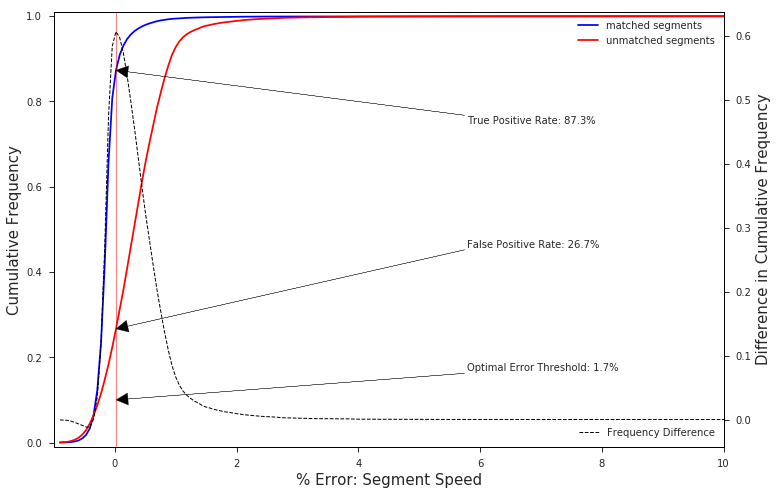

In [6]:
speedErrorThreshold = val.get_optimal_speed_error_threshold(speedDf, plot=True)

The chart above clearly shows that nearly 90% of correctly matched segments have a speed error rate of less than 1.7%, while nearly 75% of the unmatched segments, or false positive matches, lie above this value.

## 3. Map-matching Accuracy with a Global Threshold

How accurate would our data collection and aggregation process be using the threshold derived above?  Let's try it!

Statistical accuracy measures the fraction of samples correctly identified as either true positives or true negatives, or in our case, matches and misses, respectively:

$$ \text{Accuracy} = \frac{\text{True Positives} \ + \ \text{True Negatives}}{\text{Total Population}} =  \frac{\text{# Matches Kept} \ + \ \text{# Misses Discarded}}{\text{# Segments}}$$

Here's how the accuracies compare across different sample rates and noise levels:

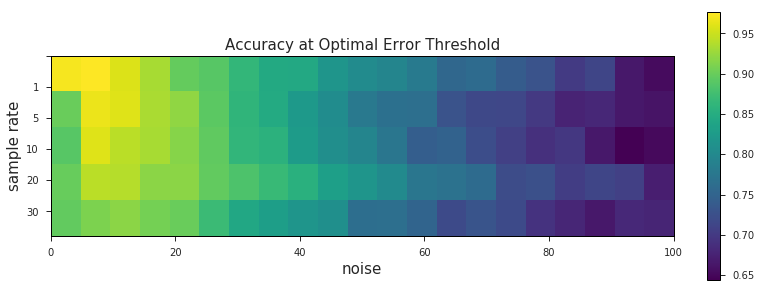

In [7]:
oneSizeFitsAll = val.plot_accuracy_heatmap(speedDf, [speedErrorThreshold], sampleRates, noiseLevels)

## 4. Map-matching Accuracy with Rate-based Thresholds

As we saw in our case study of A-OK Rides, GPS sample rate can easily be fixed by a given data provider. We can thus tune our cutoff threshold based on the sample rate which should improve the accuracy of our matches overall.

In [16]:
thresholdRateDict = {}
thresholdsByRate = []
for r, rate in enumerate(sampleRates):
    df = speedDf[speedDf['sample_rate'] == rate]
    threshold = val.get_optimal_speed_error_threshold(df, plot=False, saveFig=False)
    thresholdsByRate.append(threshold)
    thresholdRateDict[str(int(sampleRates[r]))] = threshold

In [19]:
thresholdRateDict

{'1': 0,
 '10': 0.066631693373000012,
 '20': 0.053864199086380071,
 '30': 0.074422049226850029,
 '5': 0.020375927157593399}

We can now recalculate the statistical accuracy using the rate-specific thresholds...

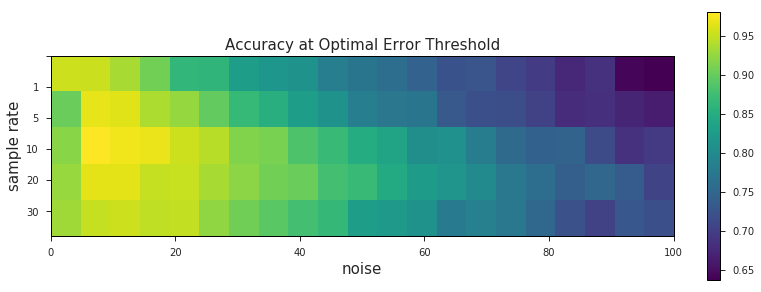

In [17]:
accBySampleRate = val.plot_accuracy_heatmap(speedDf, thresholdsByRate, sampleRates, noiseLevels)

...and visualize the change between the two:

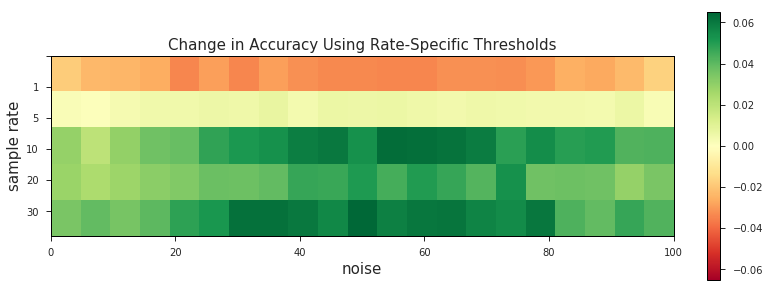

In [18]:
val.plot_change_in_acc(oneSizeFitsAll, accBySampleRate, sampleRates, noiseLevels)

These charts suggest that **prior knowledge of GPS sample rate can result in accuracy gains of up to ~6% when used in conjunction with the optimal speed error threshold**.


_\*\* N.B. - there are a number of reasons why the accuracy of 1 second sample rate matches might decrease when filtering based on the rate-specific threshold. The most likely explanation is that there either aren't enough false positives to pick a reliable threshold, or that at a 1 s sample rate, the GPS-derived speeds of the false positives just aren't different enough from the correctly matched segments._

### Weighted penalty function

We need not default to the optimal speed error threshold, which treats false positives and false negatives as equally "bad". For example, if a given customer/data provider cares more about mistakenly including bad data (Type I error) than missing good data (Type II error) a more conservative threshold can be chosen. The CDF plots above allow an analyst to visually inspect the impact that such discretionary adjustments will have on the outcome. These types of adjustments can also be performed in a programmatic fashion by assigning differential weights to our two types of error and thus shifting the optimal value itself.

## 5. Visually Inspect Speed-Based Filtering


#### Get more routes

In [102]:
vizRoutes = val.get_routes_by_length(cityName, 1, 5, 50, mapzenKey)

In [103]:
sampleRates = [1, 5, 10, 20, 30]    # specified in seconds
noiseLevels = np.linspace(0, 100, 21)    # specified in meters
noiseLevels = [60]
sampleRates = [10]
# thresh = thresholdRateDict[str(sampleRates[0])]
thresh = speedErrorThreshold

#### Synthesize new GPS traces and apply our learned parameters and thresholds

In [60]:
matchDf, speedDf, densityDf = val.get_route_metrics(cityName,
    vizRoutes, sampleRates, noiseLevels,
    speedErrThreshold=thresh)

#### Visualize the thresholding

In the maps below we've styled the output of our sample routes in order to highlight the segments and their speeds that will either make their way into the datastore or get thrown out. This is simply a way of visualizing the process that in practice would occur dynamically, and entirely behind-the-scenes. 

The original route used to generate the fake GPS measurements is shown in **<span style="color:blue">blue</span>**, along with the points along these routes that were resampled at the specified sample rate. The perturbed points that constitute the synthetic GPS measurements themselves are shown as **<span style="color:red">red</span>** circles. Segments along the matched route are colored differentially based on the specified speed error threshold. Segments that exceeded the threshold are shown in ** <span style="color:red">red</span>**, while segments that did not exceed the threshold are shown in  **<span style="color:green">green</span>**. Segments for whom a consistent match could not be found are shown in  **<span style="color:yellow">yellow</span>**.

In [3]:
dataDir = '../data/sf50thresholdViz/'

In [66]:
geojsonList = [trace for trace in os
               .listdir(dataDir) if trace.endswith('json')]
fname = dataDir + choice(geojsonList)
val.generate_route_map_2(fname, 17)

In [56]:
fname

'../data/San Francisco_route_44_w_60.0_m_noise_at_0.1_Hz.geojson'